In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
from tabulate import tabulate
np.set_printoptions(formatter={'float': lambda x: "{0:4.2f}  ".format(x)})

env = gym.make('Blackjack-v1', natural=True)

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
# Reference: https://github.com/jng985/BlackjackEnv_gym/blob/master/plot_utils.py
# https://github.com/dennybritz/reinforcement-learning
# Make some small adaptation 
def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        return V[x,y,usable_ace]

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(30, 12))
    ax = fig.add_subplot(121, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(1, ax)
    ax = fig.add_subplot(122, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(0, ax)
    plt.show()


def plot_policy(matrix, input_type='Q'):
    """
    matrix can be Q_value or policy matrix
    """

    def get_Z(x, y, usable_ace):
        if input_type == 'Q':
            prob = matrix[x,y,usable_ace]
            if prob[0] == prob[1]:
                return 1
            else:
                return np.argmax(prob)
        else:
            return matrix[x,y,usable_ace]

    def get_figure(usable_ace, ax):
        x_range = np.arange(1, 11)
        y_range = np.arange(21, 10, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(y,x,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[0.5, 11.5, 10.5, 21.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        ax.set_xlabel('Dealer\'s Showing Card')
        ax.set_ylabel('Player\'s Current Sum')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(1, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(0, ax)
    plt.show()

In [ ]:
def get_winrate(r):
    x = np.arange(1,len(r)+1)
    win = np.where(r==-1, 0, r)
    win_cum = np.cumsum(win)
    return win_cum/x

# Result from 1 Epoch
def plot_winrate(r): 
    win_rate = get_winrate(r)
    plot_start = 50
    x = np.arange(1,len(win_rate)+1)
    fig = plt.figure(figsize=(12,8))
    plt.title("Blackjack")
    plt.xlabel("Number of Episode")
    plt.ylabel("Win Rate")
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    plt.axhline(0.420, color = 'green', linestyle = '-', linewidth = 0.5)
    plt.plot(x[plot_start:], win_rate[plot_start:])
    plt.show()

# Average through mutiple Epoch
def plot_arrays(win_rate, label):
    win_rate = win_rate[:,50:]
    
    mean = np.mean(win_rate, axis=0)
    std = np.std(win_rate, axis=0)
    plt.plot(range(len(mean)), mean, label=label)
    plt.fill_between(range(len(mean)), np.maximum(mean-std, 0.3), np.minimum(mean+std, 0.5), alpha=0.3)

In [ ]:
def create_optimal_solution():
    # Create the Optimal Action, Calculated by Math
    USABLE_ACE = np.zeros((32,11), dtype=int)
    NON_USABLE_ACE = np.zeros((32,11), dtype=int)

    USABLE_ACE[18,1] = 1
    USABLE_ACE[18,9:11] = 1
    for i in range(17, -1, -1):
        USABLE_ACE[i,:] = 1

    for j in range(16, 12, -1):
        NON_USABLE_ACE[j,1] = 1
        NON_USABLE_ACE[j,7:11] = 1

    NON_USABLE_ACE[12,1:4] = 1
    NON_USABLE_ACE[12,7:11] = 1

    for k in range(11, -1, -1):
        NON_USABLE_ACE[k,:] = 1

    return np.dstack((NON_USABLE_ACE, USABLE_ACE))

OPTIMAL_SOLUTION = create_optimal_solution()
# Visualization Policy if needed
# plot_policy(OPTIMAL_SOLUTION, 'policy')

In [ ]:
def select_action(Q, state, method, epsilon, T, N, N_e, R_plus):
    """
    Action: 0(Stick), 1(Hit)
    """
    if method == 'optimal':
        return select_action_optimal(state)
    elif method == 'greedy':
        return select_action_epsilon_greedy(Q, state, epsilon)
    elif method == 'softmax':
        return select_action_softmax(Q, state, T)
    elif method == 'optimistically':
        return select_action_optimistically(Q, state, N, N_e, R_plus)
    else:
        print('Invalid Action Method')

def select_action_optimal(state):
    return OPTIMAL_SOLUTION[state]

def select_action_epsilon_greedy(Q, state, epsilon):
    r = np.random.uniform(low=0, high=1)
    if r < epsilon:
        return np.random.randint(low=0, high=2)
    else:
        return np.argmax(Q[state])

def select_action_softmax(Q, state, T):
    max_value = np.max(Q[state]/T)
    sum = np.sum(np.exp(Q[state]/T - max_value))
    prob = (np.exp(Q[state]/T - max_value)) / sum
    return np.argmax(prob)

def select_action_optimistically(Q, state, N, N_e, R_plus):
    optimistic = np.where(N[state] < N_e, R_plus, Q[state])
    return np.argmax(optimistic)

def convert_state(state):
    """
    Input: state(int, int, bool)
    the Goal of the function is to change the last component to be int
    otherwise cannot properly use numpy array index
    """
    return state[:2] + tuple([1 if state[-1] == True else 0])

def check_black_jack(state):
    if state[0] == 21:
        return True
    else:
        return False

def softmax_normalize(Q):
    sum = np.sum(np.exp(Q), 3)
    sum = np.dstack((sum, sum)).reshape(32,11,2,2)
    prob = (np.exp(Q)) / sum
    return np.max(prob,3)

In [ ]:
def Q_learning(env, num_episodes, action_method='optimistically', eval_method='mc', gamma=0.9, epsilon = 0.1, T=10, N_e=10, R_plus=1):
    '''
    Conducts active Q-learning to learn optimal Q-values. Q-values are updated during each step for a fixed number of
    episodes.
    :param env: The environment with which the agent interacts
    :param num_episodes: The number of training episodes during which experience can be collected to learn the Q-values
    :param action_method: Action selection strategy for exploration - one of {"optimistic", "softmax", "epsilon_greedy", "optimal"}
    :param eval_method: evaluation method to update Q value - one of {"mc", "td"} "Monte_Carlo" or "Temporal_Difference"
    :param gamma: Discount factor, in (0, 1]
    :param epsilon: The probability for selecting a random action in [0, 1])
    :param T: The temperature for softmax action selection
    :param N_e: Number of times a state-action pair is visited before expected utility is used instead of optimistic estimates
    :param R_plus: The best possible reward obtainable in any state
    '''
    Q = np.zeros((32,11,2,2))   # Q value
    N = np.zeros((32,11,2,2))   # Count
    episode_rewards = np.zeros(num_episodes)

    for i in tqdm(range(num_episodes)):
        state = env.reset()
        state = convert_state(state)
        # done = check_black_jack(state)
        # reward = 1.5 * done    # Win 1.5 if it is blackjack
        done = False
        episode = []
        # Go through one episode
        while not done:
            action = select_action(Q, state, action_method, epsilon, T, N, N_e, R_plus)
            next_state, reward, done, info = env.step(action)
            next_state = convert_state(next_state)

            N[state][action] += 1
            if eval_method == 'td':
                Q[state][action] = Q[state][action] + (reward + gamma * np.max(Q[next_state]) - Q[state][action]) / N[state][action]

            episode.append((state, action, reward))
            state = next_state

        episode_rewards[i] = reward

        if eval_method == 'mc':
            g = episode[-1][2] * gamma ** len(episode)
            for item in episode:
                state, action, reward = item
                Q[state][action] = Q[state][action] + (g - Q[state][action]) / N[state][action]
        
    return Q, episode_rewards

def SARSA(env, num_episodes, action_method='optimistically', gamma=0.9, epsilon = 0.1, T=10, N_e=10, R_plus=1):
    '''
    Conducts active Q-learning to learn optimal Q-values. Q-values are updated during each step for a fixed number of
    episodes.
    :param env: The environment with which the agent interacts
    :param num_episodes: The number of training episodes during which experience can be collected to learn the Q-values
    :param action_method: Action selection strategy for exploration - one of {"optimistic", "softmax", "epsilon_greedy", "optimal"}
    :param gamma: Discount factor, in (0, 1]
    :param epsilon: The probability for selecting a random action in [0, 1])
    :param T: The temperature for softmax action selection
    :param N_e: Number of times a state-action pair is visited before expected utility is used instead of optimistic estimates
    :param R_plus: The best possible reward obtainable in any state
    '''
    Q = np.zeros((32,11,2,2))   # Q value
    N = np.zeros((32,11,2,2))   # Count
    episode_rewards = np.zeros(num_episodes)

    for i in tqdm(range(num_episodes)):
        state = env.reset()
        state = convert_state(state)
        action = select_action(Q, state, action_method, epsilon, T, N, N_e, R_plus)
        # done = check_black_jack(state)
        # reward = 1.5 * done    # Win 1.5 if it is blackjack
        done = False

        j = 0
        while not done:
            next_state, reward, done, info = env.step(action)
            next_state = convert_state(next_state)
            next_action = select_action(Q, next_state, action_method, epsilon, T, N, N_e, R_plus)

            N[state][action] += 1
            Q[state][action] = Q[state][action] + (reward + gamma * Q[next_state][next_action] - Q[state][action]) / N[state][action]

            state = next_state
            action = next_action
            j += 1
        
        episode_rewards[i] = reward

    return Q, episode_rewards

In [ ]:
EPOCHS = 10
NUM_EPISODES = 400000
Q_sum = np.zeros((32,11,2,2))

for i in range(EPOCHS):
    Q, r = Q_learning(env, NUM_EPISODES, action_method='greedy', eval_method='mc')
    Q_sum += Q

100%|██████████| 400000/400000 [01:13<00:00, 5452.50it/s]


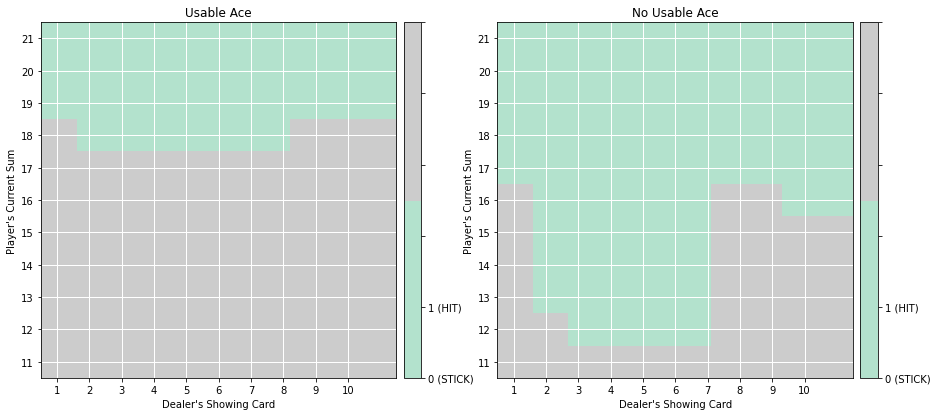

In [ ]:
plot_policy(Q_sum)

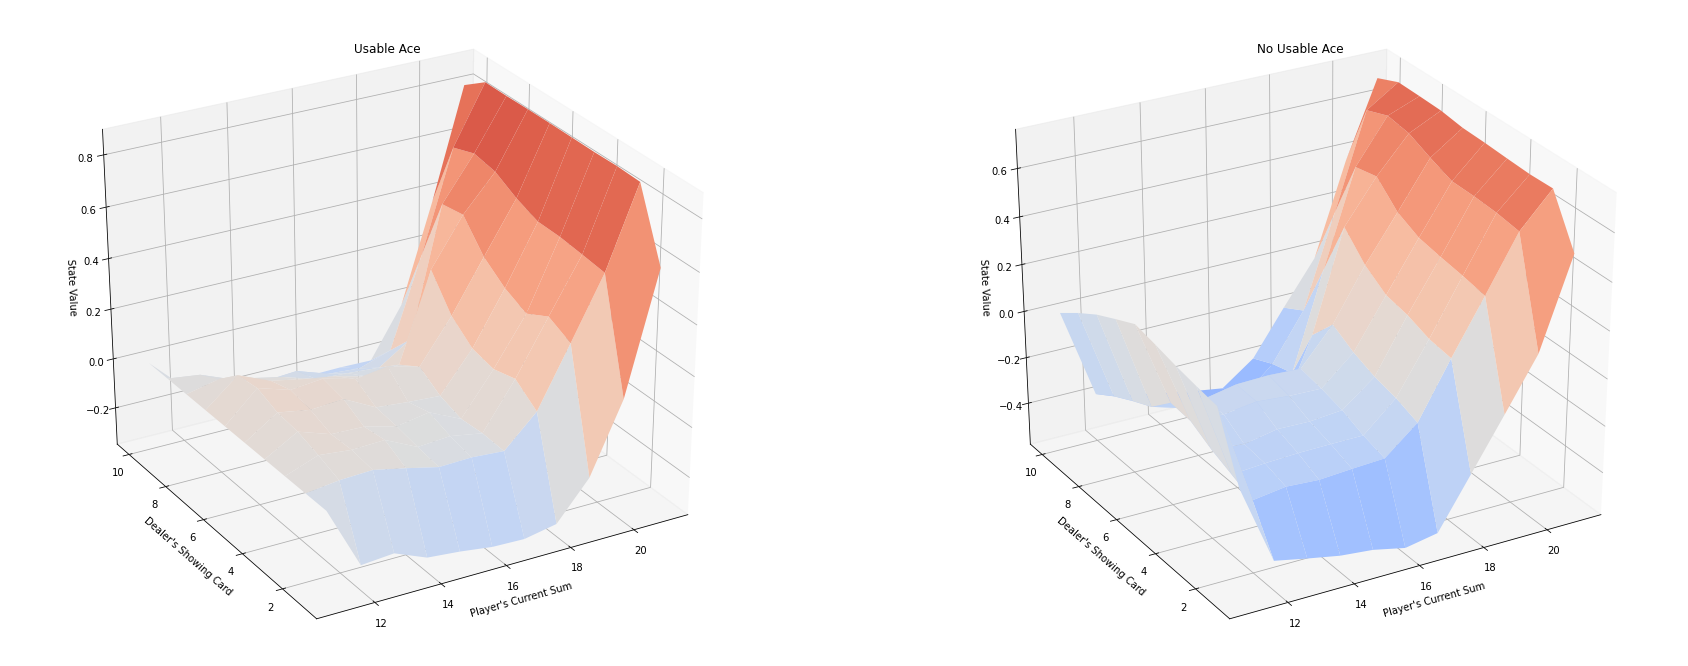

In [ ]:
plot_blackjack_values(np.max(Q_sum/10, 3))

In [ ]:
EPOCHS = 5
NUM_EPISODES = 100000
wr_optimal_mc = np.zeros((EPOCHS, NUM_EPISODES))
wr_greedy_mc = np.zeros((EPOCHS, NUM_EPISODES))
wr_softmax_mc = np.zeros((EPOCHS, NUM_EPISODES))
wr_optimistically_mc = np.zeros((EPOCHS, NUM_EPISODES))

for i in range(EPOCHS):
    Q, r = Q_learning(env, NUM_EPISODES, action_method='optimal', eval_method='mc')
    wr_optimal_mc[i] = get_winrate(r)

    Q, r = Q_learning(env, NUM_EPISODES, action_method='greedy', eval_method='mc')
    wr_greedy_mc[i] = get_winrate(r)

    Q, r = Q_learning(env, NUM_EPISODES, action_method='softmax', eval_method='mc')
    wr_softmax_mc[i] = get_winrate(r)

    Q, r = Q_learning(env, NUM_EPISODES, action_method='optimistically', eval_method='mc')
    wr_optimistically_mc[i] = get_winrate(r)

100%|██████████| 100000/100000 [00:18<00:00, 5373.61it/s]


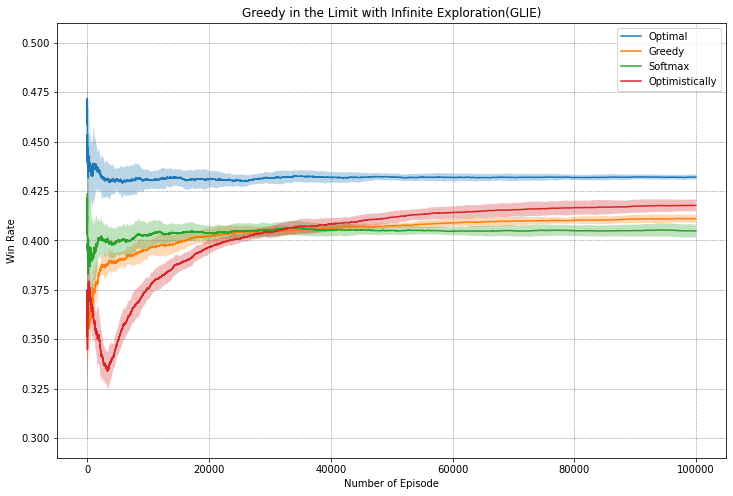

In [ ]:
fig = plt.figure(figsize=(12,8))
plot_arrays(wr_optimal_mc, 'Optimal')
plot_arrays(wr_greedy_mc,  'Greedy')
plot_arrays(wr_softmax_mc, 'Softmax')
plot_arrays(wr_optimistically_mc,'Optimistically')

plt.title("Greedy in the Limit with Infinite Exploration(GLIE)")
plt.xlabel("Number of Episode")
plt.ylabel("Win Rate")
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()
plt.show()

In [ ]:
wr_optimal_td = np.zeros((EPOCHS, NUM_EPISODES))
wr_greedy_td = np.zeros((EPOCHS, NUM_EPISODES))
wr_softmax_td = np.zeros((EPOCHS, NUM_EPISODES))
wr_optimistically_td = np.zeros((EPOCHS, NUM_EPISODES))

for i in range(EPOCHS):
    Q, r = Q_learning(env, NUM_EPISODES, action_method='optimal', eval_method='td')
    wr_optimal_td[i] = get_winrate(r)

    Q, r = Q_learning(env, NUM_EPISODES, action_method='greedy', eval_method='td')
    wr_greedy_td[i] = get_winrate(r)

    Q, r = Q_learning(env, NUM_EPISODES, action_method='softmax', eval_method='td')
    wr_softmax_td[i] = get_winrate(r)

    Q, r = Q_learning(env, NUM_EPISODES, action_method='optimistically', eval_method='td')
    wr_optimistically_td[i] = get_winrate(r)

100%|██████████| 100000/100000 [00:20<00:00, 4830.24it/s]


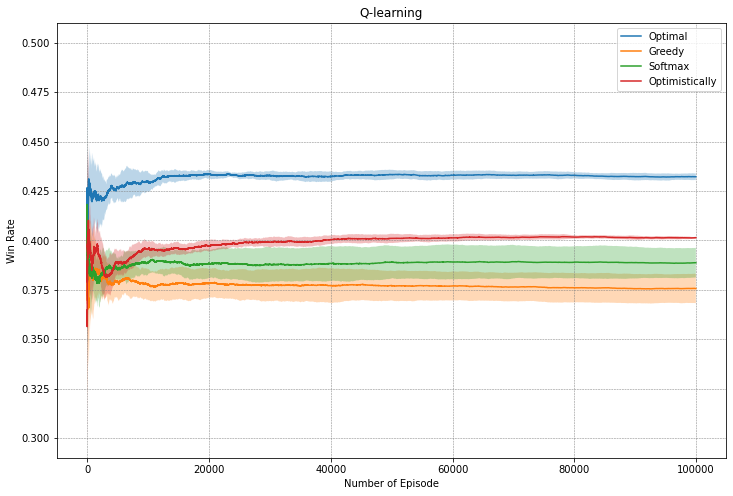

In [ ]:
fig = plt.figure(figsize=(12,8))
plot_arrays(wr_optimal_td, 'Optimal')
plot_arrays(wr_greedy_td,  'Greedy')
plot_arrays(wr_softmax_td, 'Softmax')
plot_arrays(wr_optimistically_td,'Optimistically')

plt.title("Q-learning")
plt.xlabel("Number of Episode")
plt.ylabel("Win Rate")
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()
plt.show()

In [ ]:
wr_optimal_sarsa = np.zeros((EPOCHS, NUM_EPISODES))
wr_greedy_sarsa = np.zeros((EPOCHS, NUM_EPISODES))
wr_softmax_sarsa = np.zeros((EPOCHS, NUM_EPISODES))
wr_optimistically_sarsa = np.zeros((EPOCHS, NUM_EPISODES))

for i in range(EPOCHS):
    Q, r = SARSA(env, NUM_EPISODES, action_method='optimal')
    wr_optimal_sarsa[i] = get_winrate(r)

    Q, r = SARSA(env, NUM_EPISODES, action_method='greedy')
    wr_greedy_sarsa[i] = get_winrate(r)

    Q, r = SARSA(env, NUM_EPISODES, action_method='softmax')
    wr_softmax_sarsa[i] = get_winrate(r)

    Q, r = SARSA(env, NUM_EPISODES, action_method='optimistically')
    wr_optimistically_sarsa[i] = get_winrate(r)

100%|██████████| 100000/100000 [00:20<00:00, 4842.27it/s]


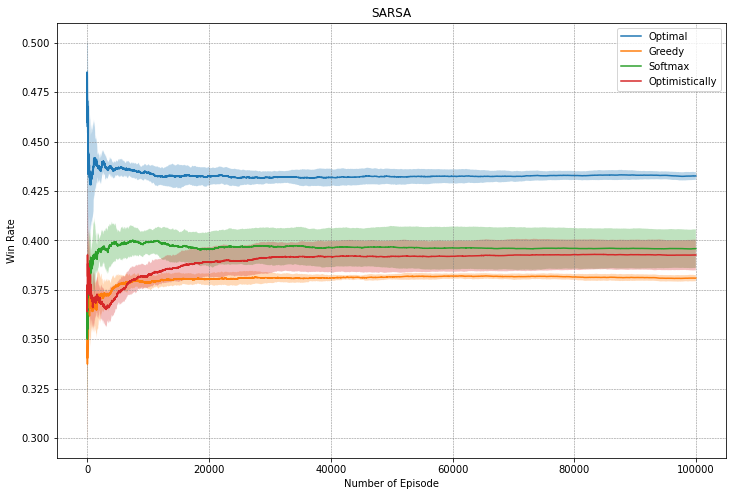

In [ ]:
fig = plt.figure(figsize=(12,8))
plot_arrays(wr_optimal_sarsa, 'Optimal')
plot_arrays(wr_greedy_sarsa,  'Greedy')
plot_arrays(wr_softmax_sarsa, 'Softmax')
plot_arrays(wr_optimistically_sarsa,'Optimistically')


plt.title("SARSA")
plt.xlabel("Number of Episode")
plt.ylabel("Win Rate")
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()
plt.show()

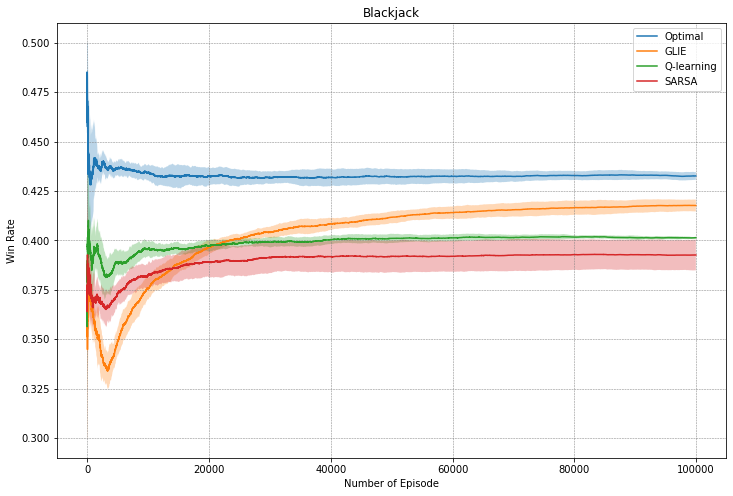

In [ ]:
fig = plt.figure(figsize=(12,8))

plot_arrays(wr_optimal_sarsa, 'Optimal')
plot_arrays(wr_optimistically_mc,'GLIE')
plot_arrays(wr_optimistically_td,'Q-learning')
plot_arrays(wr_optimistically_sarsa,'SARSA')

plt.title("Blackjack")
plt.xlabel("Number of Episode")
plt.ylabel("Win Rate")
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()
plt.show()

In [ ]:
import numpy as np
from tabulate import tabulate

m = np.array([["Optimal", np.mean(wr_optimal_sarsa[:,-1]), np.std(wr_optimal_sarsa[:,-1])], 
              ["GLIE", np.mean(wr_optimistically_mc[:,-1]), np.std(wr_optimistically_mc[:,-1])], 
              ["Q_learning", np.mean(wr_optimistically_td[:,-1]), np.std(wr_optimistically_td[:,-1])], 
              ["SARSA", np.mean(wr_optimistically_sarsa[:,-1]), np.std(wr_optimistically_sarsa[:,-1])]])
headers = ["", "Mean", "Std"]

# Generate the table in fancy format.
table = tabulate(m, headers, tablefmt="fancy_grid")

# Show it.
print(table)

╒════════════╤══════════╤═════════════╕
│            │     Mean │         Std │
╞════════════╪══════════╪═════════════╡
│ Optimal    │ 0.432612 │ 0.00196645  │
├────────────┼──────────┼─────────────┤
│ GLIE       │ 0.417636 │ 0.00295745  │
├────────────┼──────────┼─────────────┤
│ Q_learning │ 0.401348 │ 0.000475285 │
├────────────┼──────────┼─────────────┤
│ SARSA      │ 0.392608 │ 0.00773201  │
╘════════════╧══════════╧═════════════╛


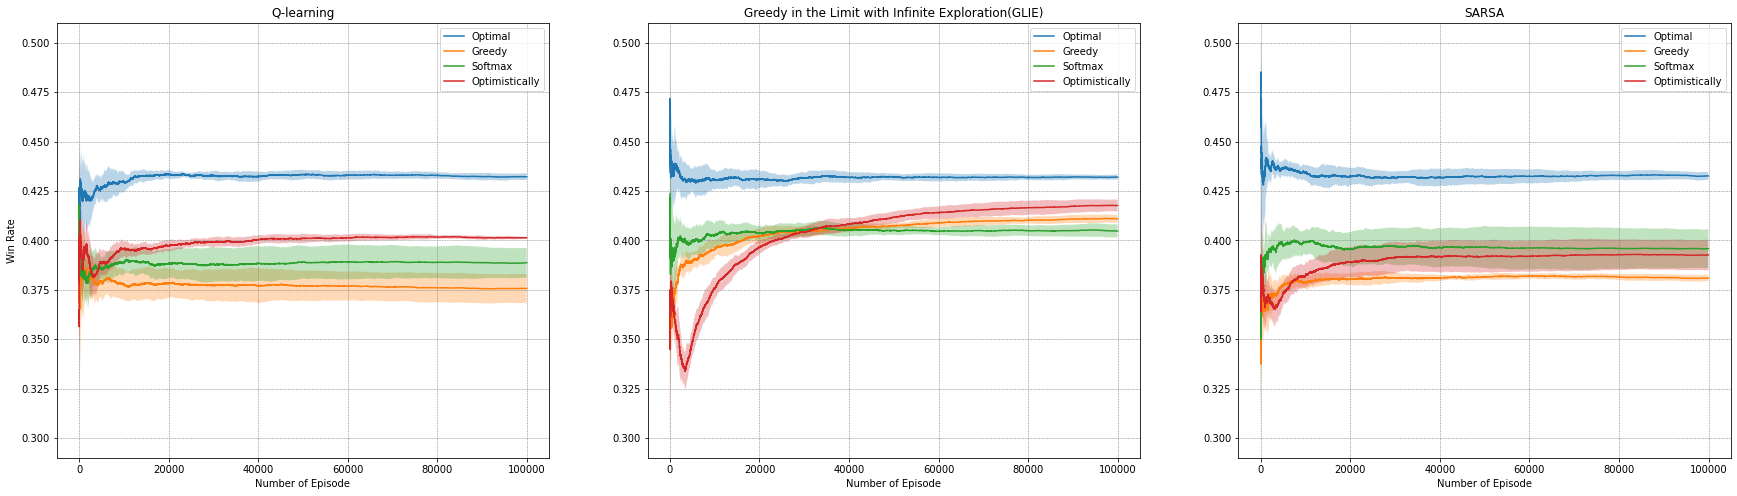

In [ ]:
fig = plt.figure(figsize=(30, 8))
ax = fig.add_subplot(131)
plot_arrays(wr_optimal_td, 'Optimal')
plot_arrays(wr_greedy_td,  'Greedy')
plot_arrays(wr_softmax_td, 'Softmax')
plot_arrays(wr_optimistically_td,'Optimistically')
plt.title("Q-learning")
plt.xlabel("Number of Episode")
plt.ylabel("Win Rate")
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()

ax = fig.add_subplot(132)
plot_arrays(wr_optimal_mc, 'Optimal')
plot_arrays(wr_greedy_mc,  'Greedy')
plot_arrays(wr_softmax_mc, 'Softmax')
plot_arrays(wr_optimistically_mc,'Optimistically')
plt.title("Greedy in the Limit with Infinite Exploration(GLIE)")
plt.xlabel("Number of Episode")
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()


ax = fig.add_subplot(133)
plot_arrays(wr_optimal_sarsa, 'Optimal')
plot_arrays(wr_greedy_sarsa,  'Greedy')
plot_arrays(wr_softmax_sarsa, 'Softmax')
plot_arrays(wr_optimistically_sarsa,'Optimistically')
plt.title("SARSA")
plt.xlabel("Number of Episode")
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()
plt.show()